In [3]:
import torch, torchvision
import numpy as np
import matplotlib.pyplot as plt
import pyro
import tqdm
import os,sys
import common
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
from torch.optim import Adam, lr_scheduler


import re, pickle
from torch.utils.data import DataLoader, random_split


In [4]:
# Reproducibility
common.set_seed(1)

In [5]:
layer_type = 'lrt'  # 'bbb' or 'lrt'
activation_type = 'softplus'  # 'softplus' or 'relu'
priors={
    'prior_mu': 0,
    'prior_sigma': 0.1,
    'posterior_mu_initial': (0, 0.1),  # (mean, std) normal_
    'posterior_rho_initial': (-5, 0.1),  # (mean, std) normal_
}
lr_start = 0.001
num_workers = 1
valid_size = 0.2
batch_size = 256
train_ens = 1
valid_ens = 1
beta_type = 0.1  
transform_mnist = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])
outputs = 10
inputs = 1

In [6]:
trainset = torchvision.datasets.MNIST(root='.', train=True, download=True, transform=transform_mnist)
num_train = len(trainset)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, 
                                           sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, 
                                           sampler=valid_sampler, num_workers=num_workers)

In [7]:
class BBBLeNet(common.ModuleWrapper):
    '''The architecture of LeNet with Bayesian Layers'''

    def __init__(self, outputs, inputs, priors, layer_type='lrt', activation_type='softplus'):
        super(BBBLeNet, self).__init__()

        self.num_classes = outputs
        self.layer_type = layer_type
        self.priors = priors

        if layer_type=='lrt':
            BBBLinear = common.layers.BBB_LRT_Linear
            BBBConv2d = common.layers.BBB_LRT_Conv2d
        elif layer_type=='bbb':
            BBBLinear = common.layers.BBB_Linear
            BBBConv2d = common.layers.BBB_Conv2d
        else:
            raise ValueError("Undefined layer_type")
        
        if activation_type=='softplus':
            self.act = nn.Softplus
        elif activation_type=='relu':
            self.act = nn.ReLU
        else:
            raise ValueError("Only softplus or relu supported")

        self.conv1 = BBBConv2d(inputs, 6, 5, padding=0, bias=True, priors=self.priors)
        self.act1 = self.act()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = BBBConv2d(6, 16, 5, padding=0, bias=True, priors=self.priors)
        self.act2 = self.act()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.flatten = common.layers.FlattenLayer(5 * 5 * 16)
        self.fc1 = BBBLinear(5 * 5 * 16, 120, bias=True, priors=self.priors)
        self.act3 = self.act()

        self.fc2 = BBBLinear(120, 84, bias=True, priors=self.priors)
        self.act4 = self.act()

        self.fc3 = BBBLinear(84, outputs, bias=True, priors=self.priors)

In [8]:
class LeNet(nn.Module):

    def __init__(self, outputs, inputs, layer_type='lrt', activation_type='softplus'):
        '''
        Base LeNet model that matches the architecture of BayesianLeNet with randomly 
        initialized weights
        '''
        super(LeNet, self).__init__()
        
        # initialization follows the BBBLeNet initialization, changing
        # BBBLinear and BBBConv2D layers to nn.Linear and nn.Conv2D
        
        if activation_type == 'softplus':
            self.act = nn.Softplus
        elif activation_type == 'relu':
            self.act = nn.ReLU

        self.conv1 = nn.Conv2d(inputs, 6, 5, padding=0, bias=True)
        self.act1 = self.act()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, 5, padding=0, bias=True)
        self.act2 = self.act()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(5 * 5 * 16, 120, bias=True)
        self.act3 = self.act()
        self.fc2 = nn.Linear(120, 84, bias=True)
        self.act4 = self.act()
        self.fc3 = nn.Linear(84, outputs, bias=True)


    def sample(self, bbbnet):
        '''
        Takes in a BBBLeNet instance and copies the structure into a LeNet model.
        Replaces the BBBLinear and BBBConv2D that uses sampling in their forward steps
        with regular nn.Linear and nn.Conv2d layers whose weights are initialized by 
        sampling the BBBLeNet model.
        '''    
        ### store activation function used by BNN, only relu and softplus  currently supported
        self.act1 = bbbnet.act()
        self.act2 = bbbnet.act()
        self.act3 = bbbnet.act()
        self.act4 = bbbnet.act()

        ### maxpool
        self.pool1 = nn.MaxPool2d(kernel_size=bbbnet.pool1.kernel_size, stride=bbbnet.pool1.stride)
        self.pool2 = nn.MaxPool2d(kernel_size=bbbnet.pool2.kernel_size, stride=bbbnet.pool2.stride)
        
        ### Create Convolution layers
        self.conv1 = nn.Conv2d(bbbnet.conv1.in_channels, bbbnet.conv1.out_channels, bbbnet.conv1.kernel_size,
                                stride=bbbnet.conv1.stride, padding=bbbnet.conv1.padding, dilation=bbbnet.conv1.dilation,
                                groups=bbbnet.conv1.groups)
        
        self.conv2 = nn.Conv2d(bbbnet.conv2.in_channels, bbbnet.conv2.out_channels, bbbnet.conv2.kernel_size,
                        stride=bbbnet.conv2.stride, padding=bbbnet.conv2.padding, dilation=bbbnet.conv2.dilation,
                        groups=bbbnet.conv2.groups)
        
        # follows the procedure for sampling in the forward methods of BBBConv and 
        # BBBLinearforward to create a fixed set of weights to use for the sampled model

        conv1_W_mu = bbbnet.conv1.W_mu
        conv1_W_rho = bbbnet.conv1.W_rho
        conv1_W_eps = torch.empty(conv1_W_mu.size()).normal_(0,1)
        conv1_W_sigma = torch.log1p(torch.exp(conv1_W_rho))
        conv1_weight = conv1_W_mu + conv1_W_eps * conv1_W_sigma
        if bbbnet.conv1.use_bias:
            conv1_bias_mu = bbbnet.conv1.bias_mu
            conv1_bias_rho = bbbnet.conv1.bias_rho
            conv1_bias_eps = torch.empty(conv1_bias_mu.size()).normal_(0,1)
            conv1_bias_sigma = torch.log1p(torch.exp(conv1_bias_rho))
            conv1_bias = conv1_bias_mu + conv1_bias_eps * conv1_bias_sigma
        else:
            conv1_bias = None
        self.conv1.weight.data = conv1_weight.data
        self.conv1.bias.data = conv1_bias.data


        conv2_W_mu = bbbnet.conv2.W_mu
        conv2_W_rho = bbbnet.conv2.W_rho
        conv2_W_eps = torch.empty(conv2_W_mu.size()).normal_(0,1)
        conv2_W_sigma = torch.log1p(torch.exp(conv2_W_rho))
        conv2_weight = conv2_W_mu + conv2_W_eps * conv2_W_sigma
        if bbbnet.conv2.use_bias:
            conv2_bias_mu = bbbnet.conv2.bias_mu
            conv2_bias_rho = bbbnet.conv2.bias_rho
            conv2_bias_eps = torch.empty(conv2_bias_mu.size()).normal_(0,1)
            conv2_bias_sigma = torch.log1p(torch.exp(conv2_bias_rho))
            conv2_bias = conv2_bias_mu + conv2_bias_eps * conv2_bias_sigma
        else:
            conv2_bias = None
        self.conv2.weight.data = conv2_weight.data
        self.conv2.bias.data = conv2_bias.data
        
        ### Create Linear Layers
        self.fc1 = nn.Linear(bbbnet.fc1.in_features, bbbnet.fc1.out_features, bbbnet.fc1.use_bias)
        self.fc2 = nn.Linear(bbbnet.fc2.in_features, bbbnet.fc2.out_features, bbbnet.fc2.use_bias)
        self.fc3 = nn.Linear(bbbnet.fc3.in_features, bbbnet.fc3.out_features, bbbnet.fc3.use_bias)

        fc1_W_mu = bbbnet.fc1.W_mu
        fc1_W_rho = bbbnet.fc1.W_rho
        fc1_W_eps = torch.empty(fc1_W_mu.size()).normal_(0,1)
        fc1_W_sigma = torch.log1p(torch.exp(fc1_W_rho))
        fc1_weight = fc1_W_mu + fc1_W_eps * fc1_W_sigma
        if bbbnet.fc1.use_bias:
            fc1_bias_mu = bbbnet.fc1.bias_mu
            fc1_bias_rho = bbbnet.fc1.bias_rho
            fc1_bias_eps = torch.empty(fc1_bias_mu.size()).normal_(0,1)
            fc1_bias_sigma = torch.log1p(torch.exp(fc1_bias_rho))
            fc1_bias = fc1_bias_mu + fc1_bias_eps * fc1_bias_sigma
        else:
            fc1_bias = None
        self.fc1.weight.data = fc1_weight.data
        self.fc1.bias.data = fc1_bias.data

        fc2_W_mu = bbbnet.fc2.W_mu
        fc2_W_rho = bbbnet.fc2.W_rho
        fc2_W_eps = torch.empty(fc2_W_mu.size()).normal_(0,1)
        fc2_W_sigma = torch.log1p(torch.exp(fc2_W_rho))
        fc2_weight = fc2_W_mu + fc2_W_eps * fc2_W_sigma
        if bbbnet.fc2.use_bias:
            fc2_bias_mu = bbbnet.fc2.bias_mu
            fc2_bias_rho = bbbnet.fc2.bias_rho
            fc2_bias_eps = torch.empty(fc2_bias_mu.size()).normal_(0,1)
            fc2_bias_sigma = torch.log1p(torch.exp(fc2_bias_rho))
            fc2_bias = fc2_bias_mu + fc2_bias_eps * fc2_bias_sigma
        else:
            fc2_bias = None
        self.fc2.weight.data = fc2_weight.data
        self.fc2.bias.data = fc2_bias.data

        fc3_W_mu = bbbnet.fc3.W_mu
        fc3_W_rho = bbbnet.fc3.W_rho
        fc3_W_eps = torch.empty(fc3_W_mu.size()).normal_(0,1)
        fc3_W_sigma = torch.log1p(torch.exp(fc3_W_rho))
        fc3_weight = fc3_W_mu + fc3_W_eps * fc3_W_sigma
        if bbbnet.fc3.use_bias:
            fc3_bias_mu = bbbnet.fc3.bias_mu
            fc3_bias_rho = bbbnet.fc3.bias_rho
            fc3_bias_eps = torch.empty(fc3_bias_mu.size()).normal_(0,1)
            fc3_bias_sigma = torch.log1p(torch.exp(fc3_bias_rho))
            fc3_bias = fc3_bias_mu + fc3_bias_eps * fc3_bias_sigma
        else:
            fc3_bias = None
        self.fc3.weight.data = fc3_weight.data
        self.fc3.bias.data = fc3_bias.data

        

    def forward(self, x):
        '''
        Forward method follow the order of BayesianLeNet
        '''
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)

        x = x.view(-1, 5 * 5 * 16)
        x = self.fc1(x)
        x = self.act3(x)
        x = self.fc2(x)
        x = self.act4(x)
        x = self.fc3(x)
        return x

In [9]:
net = BBBLeNet(outputs, inputs, priors, layer_type, activation_type)

In [13]:
def train_and_save_models(epochs = 10, K = 100, modelname = "model-cnn.pt"):
    if os.path.exists(modelname):
        print("File exists")
        return
    # Train with ELBO and Adam (Bayes by Backprop + LRT)
    criterion = common.metrics.ELBO(len(trainset))
    optimizer = Adam(net.parameters(), lr=lr_start)
    lr_sched = lr_scheduler.ReduceLROnPlateau(optimizer, patience=6, verbose=True)
    for epoch in range(epochs):  # loop over the dataset multiple times
        train_loss, train_acc, train_kl = common.train_model(net, optimizer, criterion, train_loader, 
                                                             num_ens=train_ens, beta_type=beta_type, epoch=epoch,
                                                             num_epochs=n_epochs)
        valid_loss, valid_acc = common.validate_model(net, criterion, valid_loader, num_ens=valid_ens, 
                                                      beta_type=beta_type, epoch=epoch, num_epochs=epochs)
        lr_sched.step(valid_loss)
        print('Epoch:%d, TrainLoss:%.3f, TrainAcc:%.3f, ValLoss:%.3f, ValAcc:%.3f, KL:%.3f' % (
            epoch, train_loss, train_acc, valid_loss, valid_acc, train_kl))
    # Sample k models from the posterior
    nn_dicts = []
    for i in range(K):
        sample_model = LeNet(outputs, inputs, layer_type, activation_type)
        sample_model.sample(net)
        nn_dicts += [sample_model.state_dict()]
    # Save the models
    torch.save(nn_dicts, modelname)
    print("Saved %d models" % K)

In [10]:
def load_models(K = 100):
    # Load the models
    sampled_models = [LeNet(outputs, inputs, layer_type, activation_type) for i in range(K)]
    for net, state_dict in zip(sampled_models, torch.load('models/model-cnn.pt')):
        net.load_state_dict(state_dict)
    print("Loaded %d sample models" % K)
    return sampled_models

In [ ]:
train_and_save_models(epochs = 20, K = 1000, modelname = "model-cnn.pt")

In [49]:
sampled_models = load_models(K = 50)

Loaded 50 sample models


## Train without Adversarial Examples

In [20]:
# Train dataset
train_dataset = torchvision.datasets.MNIST('.', train=True, download=True,
                       transform=transform_mnist)

# Train data loader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

In [47]:
# HyperParameters
epochs = 20
modelname = "CNN_v2"

# Train with BinaryCrossEntropy
val_losses = []
model      = LeNet(outputs, inputs, layer_type, activation_type)
optimizer  = torch.optim.Adam(model.parameters(), lr=0.001)
# lr_sched   = lr_scheduler.ReduceLROnPlateau(optimizer, patience=6, verbose=True)
loss_fcn   = torch.nn.CrossEntropyLoss(reduction="mean")
softmax    = torch.nn.Softmax()

for epoch in range(epochs):
    total_loss = 0.
    model.train()
    for data in train_loader:
        images, labels = data
        y    = softmax(model(images))
        loss = loss_fcn(y, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()        
        total_loss += loss.item()
    # lr_sched.step()
    total_loss /= len(train_loader.dataset)
    print("Epoch %g: Loss = %g" % (epoch, total_loss))

torch.save(model, "models/%s.pt" % modelname)
print("Saved the model")

Epoch 0: Loss = 0.027148
Epoch 1: Loss = 0.0240098
Epoch 2: Loss = 0.0233979
Epoch 3: Loss = 0.0233313
Epoch 4: Loss = 0.0232598
Epoch 5: Loss = 0.0231919
Epoch 6: Loss = 0.0232035
Epoch 7: Loss = 0.0231663
Epoch 8: Loss = 0.0231402
Epoch 9: Loss = 0.0231431
Epoch 10: Loss = 0.0231321
Epoch 11: Loss = 0.0231338
Epoch 12: Loss = 0.0231039
Epoch 13: Loss = 0.0231189
Epoch 14: Loss = 0.023094
Epoch 15: Loss = 0.0231079
Epoch 16: Loss = 0.0231121
Epoch 17: Loss = 0.0230984
Epoch 18: Loss = 0.0230931
Epoch 19: Loss = 0.0230665
Saved the model


## Adversarial Training

In [135]:
# Train dataset
train_dataset = torchvision.datasets.MNIST('.', train=True, download=True,
                       transform=transform_mnist)

In [136]:
transform_back = transforms.Compose([transforms.Resize((28,28))])

In [137]:
dirs    = [d for d in os.listdir("mnist_adv_CNN_0.05/") if d.startswith("train_images_med")]
dir_ord = sorted([int(re.findall("[0-9]+",d)[0]) for d in dirs])
dirs    = sorted(dirs, key=lambda x: dir_ord.index(int(re.findall("[0-9]+",x)[0])))

In [138]:
images  = []
targets = []
for d in dirs:
    with open("mnist_adv_CNN_0.05//" + d, 'rb') as handle:
        temp = pickle.load(handle)
        images.append(temp["images"])
        targets.append(temp["labels"])
        
images  = torch.vstack(images)
images  = transform_back(images)
images  = images[:,0,:,:]

targets = torch.hstack(targets)

In [140]:
train_dataset.data    = torch.vstack([train_dataset.data, images])
train_dataset.targets = torch.hstack([train_dataset.targets, targets])

train, val = random_split(train_dataset,[50000+images.shape[0],10000], generator=torch.Generator().manual_seed(156))

# Train data loader
train_loader = torch.utils.data.DataLoader(train, batch_size=128, shuffle=True)
valid_loader = torch.utils.data.DataLoader(val  , batch_size=128, shuffle=True)

In [141]:
img = next(iter(train_loader))

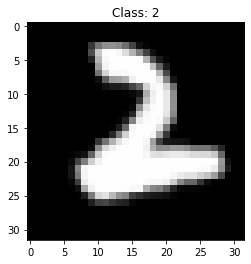

In [142]:
ind = 10 # try 1
plt.figure()
plt.imshow(img[0][ind,0,:,:], cmap='gray')
plt.title("Class: %s" % img[1][ind].item())
plt.show()

In [143]:
def train_and_save_models(epochs = 10, K = 100, modelname = "model-cnn-adv.pt"):
    if os.path.exists(modelname):
        print("File exists")
        return
    # Train with ELBO and Adam (Bayes by Backprop + LRT)
    criterion = common.metrics.ELBO(len(trainset))
    optimizer = Adam(net.parameters(), lr=lr_start)
    lr_sched = lr_scheduler.ReduceLROnPlateau(optimizer, patience=6, verbose=True)
    for epoch in range(epochs):  # loop over the dataset multiple times
        train_loss, train_acc, train_kl = common.train_model(net, optimizer, criterion, train_loader, 
                                                             num_ens=train_ens, beta_type=beta_type, epoch=epoch,
                                                             num_epochs=epochs)
        valid_loss, valid_acc = common.validate_model(net, criterion, valid_loader, num_ens=valid_ens, 
                                                      beta_type=beta_type, epoch=epoch, num_epochs=epochs)
        lr_sched.step(valid_loss)
        print('Epoch:%d, TrainLoss:%.3f, TrainAcc:%.3f, ValLoss:%.3f, ValAcc:%.3f, KL:%.3f' % (
            epoch, train_loss, train_acc, valid_loss, valid_acc, train_kl))
    # Sample k models from the posterior
    nn_dicts = []
    for i in range(K):
        sample_model = LeNet(outputs, inputs, layer_type, activation_type)
        sample_model.sample(net)
        nn_dicts += [sample_model.state_dict()]
    # Save the models
    torch.save(nn_dicts, modelname)
    print("Saved %d models" % K)

In [144]:
train_and_save_models(epochs = 20, K = 1000, modelname = "model-cnn-adv-med0.05.pt")

Epoch:0, TrainLoss:8949.661, TrainAcc:0.973, ValLoss:8815.307, ValAcc:0.975, KL:35952.331
Epoch:1, TrainLoss:8331.902, TrainAcc:0.975, ValLoss:8980.602, ValAcc:0.973, KL:35115.529
Epoch:2, TrainLoss:7778.730, TrainAcc:0.978, ValLoss:8261.433, ValAcc:0.977, KL:34635.471
Epoch:3, TrainLoss:7666.301, TrainAcc:0.978, ValLoss:8226.040, ValAcc:0.975, KL:34100.247
Epoch:4, TrainLoss:7431.978, TrainAcc:0.979, ValLoss:8325.451, ValAcc:0.976, KL:33713.422
Epoch:5, TrainLoss:7143.370, TrainAcc:0.981, ValLoss:8008.452, ValAcc:0.976, KL:33158.879
Epoch:6, TrainLoss:6964.101, TrainAcc:0.980, ValLoss:8216.730, ValAcc:0.975, KL:32673.102
Epoch:7, TrainLoss:6826.943, TrainAcc:0.982, ValLoss:8213.214, ValAcc:0.975, KL:32222.349
Epoch:8, TrainLoss:6733.833, TrainAcc:0.982, ValLoss:7880.064, ValAcc:0.977, KL:31912.593
Epoch:9, TrainLoss:6353.305, TrainAcc:0.983, ValLoss:7803.279, ValAcc:0.980, KL:31599.982
Epoch:10, TrainLoss:6362.029, TrainAcc:0.983, ValLoss:7619.875, ValAcc:0.979, KL:31359.545
Epoch:11,

## Adversarial Training Champ

In [145]:
# Train dataset
train_dataset = torchvision.datasets.MNIST('.', train=True, download=True,
                       transform=transform_mnist)

In [146]:
transform_back = transforms.Compose([transforms.Resize((28,28))])

In [147]:
dirs    = [d for d in os.listdir("mnist_adv_CNN_0.05/") if d.startswith("train_images_champ")]
dir_ord = sorted([int(re.findall("[0-9]+",d)[0]) for d in dirs])
dirs    = sorted(dirs, key=lambda x: dir_ord.index(int(re.findall("[0-9]+",x)[0])))

In [148]:
images  = []
targets = []
for d in dirs:
    with open("mnist_adv_CNN_0.05/" + d, 'rb') as handle:
        temp = pickle.load(handle)
        images.append(temp["images"])
        targets.append(temp["labels"])
        
images  = torch.vstack(images)
images  = transform_back(images)
images  = images[:,0,:,:]

targets = torch.hstack(targets)

In [150]:
train_dataset.data    = torch.vstack([train_dataset.data, images])
train_dataset.targets = torch.hstack([train_dataset.targets, targets])

train, val = random_split(train_dataset,[50000+images.shape[0],10000], generator=torch.Generator().manual_seed(156))

# Train data loader
train_loader = torch.utils.data.DataLoader(train, batch_size=128, shuffle=True)
valid_loader = torch.utils.data.DataLoader(val  , batch_size=128, shuffle=True)

In [151]:
img = next(iter(train_loader))

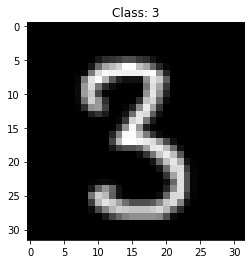

In [152]:
ind = 10 # try 1
plt.figure()
plt.imshow(img[0][ind,0,:,:], cmap='gray')
plt.title("Class: %s" % img[1][ind].item())
plt.show()

In [153]:
train_and_save_models(epochs = 20, K = 1000, modelname = "model-cnn-adv-champ0.05.pt")

Epoch:0, TrainLoss:5748.950, TrainAcc:0.985, ValLoss:7297.304, ValAcc:0.978, KL:28318.823
Epoch:1, TrainLoss:5604.724, TrainAcc:0.986, ValLoss:6953.296, ValAcc:0.982, KL:28425.381
Epoch:2, TrainLoss:5523.580, TrainAcc:0.986, ValLoss:7027.331, ValAcc:0.980, KL:28654.955
Epoch:3, TrainLoss:5468.697, TrainAcc:0.987, ValLoss:6825.225, ValAcc:0.982, KL:28711.553
Epoch:4, TrainLoss:5469.264, TrainAcc:0.987, ValLoss:7226.810, ValAcc:0.982, KL:28803.916
Epoch:5, TrainLoss:5562.123, TrainAcc:0.986, ValLoss:6808.629, ValAcc:0.981, KL:29043.431
Epoch:6, TrainLoss:5333.678, TrainAcc:0.988, ValLoss:6939.312, ValAcc:0.982, KL:29171.288
Epoch:7, TrainLoss:5457.837, TrainAcc:0.987, ValLoss:7125.187, ValAcc:0.981, KL:29041.696
Epoch:8, TrainLoss:5298.181, TrainAcc:0.988, ValLoss:7094.158, ValAcc:0.981, KL:28945.895
Epoch:9, TrainLoss:5208.028, TrainAcc:0.988, ValLoss:7566.662, ValAcc:0.981, KL:28774.984
Epoch:10, TrainLoss:5101.284, TrainAcc:0.988, ValLoss:6604.559, ValAcc:0.982, KL:28617.199
Epoch:11,

## Adversarial Training Mean

In [83]:
# Train dataset
train_dataset = torchvision.datasets.MNIST('.', train=True, download=True,
                       transform=transform_mnist)

In [84]:
transform_back = transforms.Compose([transforms.Resize((28,28))])

In [85]:
dirs    = [d for d in os.listdir("mnist_adv_CNN_0.05/") if d.startswith("train_images_mean")]
dir_ord = sorted([int(re.findall("[0-9]+",d)[0]) for d in dirs])
dirs    = sorted(dirs, key=lambda x: dir_ord.index(int(re.findall("[0-9]+",x)[0])))

In [86]:
images  = []
targets = []
for d in dirs:
    with open("mnist_adv_CNN_0.05/" + d, 'rb') as handle:
        temp = pickle.load(handle)
        images.append(temp["images"])
        targets.append(temp["labels"])
        
images  = torch.vstack(images)
images  = transform_back(images)
images  = images[:,0,:,:]

targets = torch.hstack(targets)

In [87]:
train_dataset.data    = torch.vstack([train_dataset.data, images])
train_dataset.targets = torch.hstack([train_dataset.targets, targets])

train, val = random_split(train_dataset,[50000+images.shape[0],10000], generator=torch.Generator().manual_seed(156))

# Train data loader
train_loader = torch.utils.data.DataLoader(train, batch_size=128, shuffle=True)
valid_loader = torch.utils.data.DataLoader(val  , batch_size=128, shuffle=True)

In [88]:
img = next(iter(train_loader))

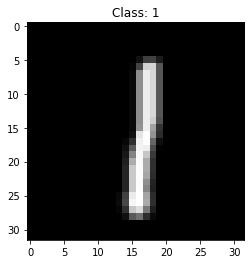

In [89]:
ind = 10 # try 1
plt.figure()
plt.imshow(img[0][ind,0,:,:], cmap='gray')
plt.title("Class: %s" % img[1][ind].item())
plt.show()

In [90]:
train_and_save_models(epochs = 20, K = 1000, modelname = "model-cnn-adv-mean0.05.pt")

File exists


## Adversarial Training (eps= 0.18)

In [58]:
# Train dataset
train_dataset = torchvision.datasets.MNIST('.', train=True, download=True,
                       transform=transform_mnist)

In [59]:
transform_back = transforms.Compose([transforms.Resize((28,28))])

In [60]:
dirs    = [d for d in os.listdir("mnist_adv_CNN_0.18/") if d.startswith("train_images_med")]
dir_ord = sorted([int(re.findall("[0-9]+",d)[0]) for d in dirs])
dirs    = sorted(dirs, key=lambda x: dir_ord.index(int(re.findall("[0-9]+",x)[0])))

In [61]:
images  = []
targets = []
for d in dirs:
    with open("mnist_adv_CNN_0.18/" + d, 'rb') as handle:
        temp = pickle.load(handle)
        images.append(temp["images"])
        targets.append(temp["labels"])
        
images  = torch.vstack(images)
images  = transform_back(images)
images  = images[:,0,:,:]

targets = torch.hstack(targets)

In [62]:
train_dataset.data    = torch.vstack([train_dataset.data, images])
train_dataset.targets = torch.hstack([train_dataset.targets, targets])

train, val = random_split(train_dataset,[50000+images.shape[0],10000], generator=torch.Generator().manual_seed(156))

# Train data loader
train_loader = torch.utils.data.DataLoader(train, batch_size=128, shuffle=True)
valid_loader = torch.utils.data.DataLoader(val  , batch_size=128, shuffle=True)

In [63]:
img = next(iter(train_loader))

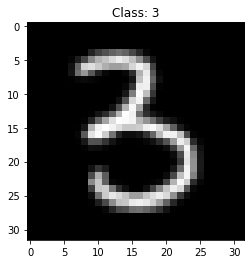

In [64]:
ind = 10 # try 1
plt.figure()
plt.imshow(img[0][ind,0,:,:], cmap='gray')
plt.title("Class: %s" % img[1][ind].item())
plt.show()

In [65]:
def train_and_save_models(epochs = 10, K = 100, modelname = "model-cnn-adv.pt"):
    if os.path.exists(modelname):
        print("File exists")
        return
    # Train with ELBO and Adam (Bayes by Backprop + LRT)
    criterion = common.metrics.ELBO(len(trainset))
    optimizer = Adam(net.parameters(), lr=lr_start)
    lr_sched = lr_scheduler.ReduceLROnPlateau(optimizer, patience=6, verbose=True)
    for epoch in range(epochs):  # loop over the dataset multiple times
        train_loss, train_acc, train_kl = common.train_model(net, optimizer, criterion, train_loader, 
                                                             num_ens=train_ens, beta_type=beta_type, epoch=epoch,
                                                             num_epochs=epochs)
        valid_loss, valid_acc = common.validate_model(net, criterion, valid_loader, num_ens=valid_ens, 
                                                      beta_type=beta_type, epoch=epoch, num_epochs=epochs)
        lr_sched.step(valid_loss)
        print('Epoch:%d, TrainLoss:%.3f, TrainAcc:%.3f, ValLoss:%.3f, ValAcc:%.3f, KL:%.3f' % (
            epoch, train_loss, train_acc, valid_loss, valid_acc, train_kl))
    # Sample k models from the posterior
    nn_dicts = []
    for i in range(K):
        sample_model = LeNet(outputs, inputs, layer_type, activation_type)
        sample_model.sample(net)
        nn_dicts += [sample_model.state_dict()]
    # Save the models
    torch.save(nn_dicts, modelname)
    print("Saved %d models" % K)

In [184]:
train_and_save_models(epochs = 20, K = 1000, modelname = "models/model-cnn-adv-med0.18.pt")

Epoch:0, TrainLoss:6328.549, TrainAcc:0.982, ValLoss:6058.759, ValAcc:0.983, KL:28087.034
Epoch:1, TrainLoss:6107.050, TrainAcc:0.983, ValLoss:6719.151, ValAcc:0.980, KL:28581.676
Epoch:2, TrainLoss:5874.656, TrainAcc:0.985, ValLoss:6654.492, ValAcc:0.980, KL:28847.441
Epoch:3, TrainLoss:5688.220, TrainAcc:0.986, ValLoss:6139.992, ValAcc:0.982, KL:29071.327
Epoch:4, TrainLoss:5593.068, TrainAcc:0.986, ValLoss:6237.446, ValAcc:0.982, KL:29128.288
Epoch:5, TrainLoss:5347.973, TrainAcc:0.988, ValLoss:6199.795, ValAcc:0.984, KL:28983.227
Epoch:6, TrainLoss:5237.087, TrainAcc:0.988, ValLoss:6407.690, ValAcc:0.983, KL:28864.655
Epoch     8: reducing learning rate of group 0 to 1.0000e-04.
Epoch:7, TrainLoss:5344.323, TrainAcc:0.987, ValLoss:6852.710, ValAcc:0.982, KL:28852.665
Epoch:8, TrainLoss:4919.120, TrainAcc:0.989, ValLoss:5830.979, ValAcc:0.985, KL:28871.863
Epoch:9, TrainLoss:4996.001, TrainAcc:0.989, ValLoss:5803.739, ValAcc:0.985, KL:28731.249
Epoch:10, TrainLoss:4837.497, TrainAcc

## Adversarial Training (eps= 0.18, champ)

In [185]:
# Train dataset
train_dataset = torchvision.datasets.MNIST('.', train=True, download=True,
                       transform=transform_mnist)

In [186]:
transform_back = transforms.Compose([transforms.Resize((28,28))])

In [187]:
dirs    = [d for d in os.listdir("mnist_adv_CNN_0.18/") if d.startswith("train_images_champ")]
dir_ord = sorted([int(re.findall("[0-9]+",d)[0]) for d in dirs])
dirs    = sorted(dirs, key=lambda x: dir_ord.index(int(re.findall("[0-9]+",x)[0])))

In [188]:
images  = []
targets = []
for d in dirs:
    with open("mnist_adv_CNN_0.18/" + d, 'rb') as handle:
        temp = pickle.load(handle)
        images.append(temp["images"])
        targets.append(temp["labels"])
        
images  = torch.vstack(images)
images  = transform_back(images)
images  = images[:,0,:,:]

targets = torch.hstack(targets)

In [189]:
train_dataset.data    = torch.vstack([train_dataset.data, images])
train_dataset.targets = torch.hstack([train_dataset.targets, targets])

train, val = random_split(train_dataset,[50000+images.shape[0],10000], generator=torch.Generator().manual_seed(156))

# Train data loader
train_loader = torch.utils.data.DataLoader(train, batch_size=128, shuffle=True)
valid_loader = torch.utils.data.DataLoader(val  , batch_size=128, shuffle=True)

In [190]:
img = next(iter(train_loader))

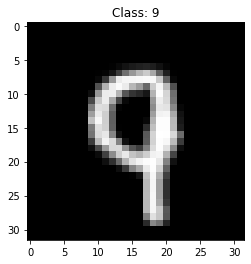

In [191]:
ind = 10 # try 1
plt.figure()
plt.imshow(img[0][ind,0,:,:], cmap='gray')
plt.title("Class: %s" % img[1][ind].item())
plt.show()

In [192]:
def train_and_save_models(epochs = 10, K = 100, modelname = "model-cnn-adv.pt"):
    if os.path.exists(modelname):
        print("File exists")
        return
    # Train with ELBO and Adam (Bayes by Backprop + LRT)
    criterion = common.metrics.ELBO(len(trainset))
    optimizer = Adam(net.parameters(), lr=lr_start)
    lr_sched = lr_scheduler.ReduceLROnPlateau(optimizer, patience=6, verbose=True)
    for epoch in range(epochs):  # loop over the dataset multiple times
        train_loss, train_acc, train_kl = common.train_model(net, optimizer, criterion, train_loader, 
                                                             num_ens=train_ens, beta_type=beta_type, epoch=epoch,
                                                             num_epochs=epochs)
        valid_loss, valid_acc = common.validate_model(net, criterion, valid_loader, num_ens=valid_ens, 
                                                      beta_type=beta_type, epoch=epoch, num_epochs=epochs)
        lr_sched.step(valid_loss)
        print('Epoch:%d, TrainLoss:%.3f, TrainAcc:%.3f, ValLoss:%.3f, ValAcc:%.3f, KL:%.3f' % (
            epoch, train_loss, train_acc, valid_loss, valid_acc, train_kl))
    # Sample k models from the posterior
    nn_dicts = []
    for i in range(K):
        sample_model = LeNet(outputs, inputs, layer_type, activation_type)
        sample_model.sample(net)
        nn_dicts += [sample_model.state_dict()]
    # Save the models
    torch.save(nn_dicts, modelname)
    print("Saved %d models" % K)

In [193]:
train_and_save_models(epochs = 20, K = 1000, modelname = "models/model-cnn-adv-champ0.18.pt")

Epoch:0, TrainLoss:5160.353, TrainAcc:0.987, ValLoss:6292.461, ValAcc:0.982, KL:27207.201
Epoch:1, TrainLoss:5070.413, TrainAcc:0.988, ValLoss:6765.373, ValAcc:0.981, KL:27369.277
Epoch:2, TrainLoss:5380.323, TrainAcc:0.987, ValLoss:6474.751, ValAcc:0.984, KL:27846.429
Epoch:3, TrainLoss:5080.209, TrainAcc:0.988, ValLoss:6512.425, ValAcc:0.983, KL:28110.186
Epoch:4, TrainLoss:5079.756, TrainAcc:0.988, ValLoss:6503.413, ValAcc:0.982, KL:28056.009
Epoch:5, TrainLoss:5125.309, TrainAcc:0.988, ValLoss:6360.784, ValAcc:0.983, KL:28119.157
Epoch:6, TrainLoss:4976.825, TrainAcc:0.989, ValLoss:6396.181, ValAcc:0.983, KL:28137.779
Epoch:7, TrainLoss:4958.926, TrainAcc:0.989, ValLoss:5970.411, ValAcc:0.984, KL:28019.700
Epoch:8, TrainLoss:4828.485, TrainAcc:0.989, ValLoss:7112.312, ValAcc:0.982, KL:27940.775
Epoch:9, TrainLoss:4892.673, TrainAcc:0.989, ValLoss:6161.597, ValAcc:0.985, KL:27869.739
Epoch:10, TrainLoss:4908.512, TrainAcc:0.989, ValLoss:6152.966, ValAcc:0.985, KL:27877.910
Epoch:11,

## Adversarial Training (eps= 0.18, mean)

In [66]:
# Train dataset
train_dataset = torchvision.datasets.MNIST('.', train=True, download=True,
                       transform=transform_mnist)

In [67]:
transform_back = transforms.Compose([transforms.Resize((28,28))])

In [68]:
dirs    = [d for d in os.listdir("mnist_adv_CNN_0.18/") if d.startswith("train_images_mean")]
dir_ord = sorted([int(re.findall("[0-9]+",d)[0]) for d in dirs])
dirs    = sorted(dirs, key=lambda x: dir_ord.index(int(re.findall("[0-9]+",x)[0])))

In [69]:
images  = []
targets = []
for d in dirs:
    with open("mnist_adv_CNN_0.18/" + d, 'rb') as handle:
        temp = pickle.load(handle)
        images.append(temp["images"])
        targets.append(temp["labels"])
        
images  = torch.vstack(images)
images  = transform_back(images)
images  = images[:,0,:,:]

targets = torch.hstack(targets)

In [70]:
train_dataset.data    = torch.vstack([train_dataset.data, images])
train_dataset.targets = torch.hstack([train_dataset.targets, targets])

train, val = random_split(train_dataset,[50000+images.shape[0],10000], generator=torch.Generator().manual_seed(156))

# Train data loader
train_loader = torch.utils.data.DataLoader(train, batch_size=128, shuffle=True)
valid_loader = torch.utils.data.DataLoader(val  , batch_size=128, shuffle=True)

In [71]:
img = next(iter(train_loader))

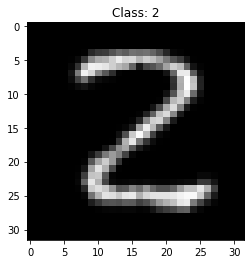

In [72]:
ind = 10 # try 1
plt.figure()
plt.imshow(img[0][ind,0,:,:], cmap='gray')
plt.title("Class: %s" % img[1][ind].item())
plt.show()

In [73]:
def train_and_save_models(epochs = 10, K = 100, modelname = "model-cnn-adv.pt"):
    if os.path.exists(modelname):
        print("File exists")
        return
    # Train with ELBO and Adam (Bayes by Backprop + LRT)
    criterion = common.metrics.ELBO(len(trainset))
    optimizer = Adam(net.parameters(), lr=lr_start)
    lr_sched = lr_scheduler.ReduceLROnPlateau(optimizer, patience=6, verbose=True)
    for epoch in range(epochs):  # loop over the dataset multiple times
        train_loss, train_acc, train_kl = common.train_model(net, optimizer, criterion, train_loader, 
                                                             num_ens=train_ens, beta_type=beta_type, epoch=epoch,
                                                             num_epochs=epochs)
        valid_loss, valid_acc = common.validate_model(net, criterion, valid_loader, num_ens=valid_ens, 
                                                      beta_type=beta_type, epoch=epoch, num_epochs=epochs)
        lr_sched.step(valid_loss)
        print('Epoch:%d, TrainLoss:%.3f, TrainAcc:%.3f, ValLoss:%.3f, ValAcc:%.3f, KL:%.3f' % (
            epoch, train_loss, train_acc, valid_loss, valid_acc, train_kl))
    # Sample k models from the posterior
    nn_dicts = []
    for i in range(K):
        sample_model = LeNet(outputs, inputs, layer_type, activation_type)
        sample_model.sample(net)
        nn_dicts += [sample_model.state_dict()]
    # Save the models
    torch.save(nn_dicts, modelname)
    print("Saved %d models" % K)

In [74]:
train_and_save_models(epochs = 20, K = 1000, modelname = "models/model-cnn-adv-mean0.18.pt")

Epoch:0, TrainLoss:6988.521, TrainAcc:0.978, ValLoss:6624.928, ValAcc:0.980, KL:26125.820
Epoch:1, TrainLoss:6046.010, TrainAcc:0.983, ValLoss:6339.429, ValAcc:0.981, KL:26684.099
Epoch:2, TrainLoss:5653.364, TrainAcc:0.985, ValLoss:6168.116, ValAcc:0.982, KL:27106.052
Epoch:3, TrainLoss:5598.903, TrainAcc:0.985, ValLoss:6065.987, ValAcc:0.982, KL:27328.547
Epoch:4, TrainLoss:5461.733, TrainAcc:0.986, ValLoss:5892.176, ValAcc:0.984, KL:27465.236
Epoch:5, TrainLoss:5351.436, TrainAcc:0.987, ValLoss:5600.215, ValAcc:0.985, KL:27498.719
Epoch:6, TrainLoss:5137.735, TrainAcc:0.988, ValLoss:5911.918, ValAcc:0.983, KL:27595.175
Epoch:7, TrainLoss:5082.059, TrainAcc:0.988, ValLoss:5602.695, ValAcc:0.985, KL:27467.322
Epoch:8, TrainLoss:5074.883, TrainAcc:0.988, ValLoss:6210.474, ValAcc:0.983, KL:27352.501
Epoch:9, TrainLoss:4868.651, TrainAcc:0.989, ValLoss:5919.469, ValAcc:0.985, KL:27317.718
Epoch:10, TrainLoss:4790.870, TrainAcc:0.989, ValLoss:5487.045, ValAcc:0.985, KL:27164.760
Epoch:11,

## Adversarial Training (eps=0.50)

In [11]:
# Train dataset
train_dataset = torchvision.datasets.MNIST('.', train=True, download=True,
                       transform=transform_mnist)

In [12]:
transform_back = transforms.Compose([transforms.Resize((28,28))])

In [15]:
dirs    = [d for d in os.listdir("mnist_adv_CNN_0.50/") if d.startswith("train_images_med")]
dir_ord = sorted([int(re.findall("[0-9]+",d)[0]) for d in dirs])
dirs    = sorted(dirs, key=lambda x: dir_ord.index(int(re.findall("[0-9]+",x)[0])))

In [16]:
images  = []
targets = []
for d in dirs:
    with open("mnist_adv_CNN_0.50/" + d, 'rb') as handle:
        temp = pickle.load(handle)
        images.append(temp["images"])
        targets.append(temp["labels"])
        
images  = torch.vstack(images)
images  = transform_back(images)
images  = images[:,0,:,:]

targets = torch.hstack(targets)

In [17]:
train_dataset.data    = torch.vstack([train_dataset.data, images])
train_dataset.targets = torch.hstack([train_dataset.targets, targets])

train, val = random_split(train_dataset,[50000+images.shape[0],10000], generator=torch.Generator().manual_seed(156))

# Train data loader
train_loader = torch.utils.data.DataLoader(train, batch_size=128, shuffle=True)
valid_loader = torch.utils.data.DataLoader(val  , batch_size=128, shuffle=True)

In [20]:
img = next(iter(train_loader))

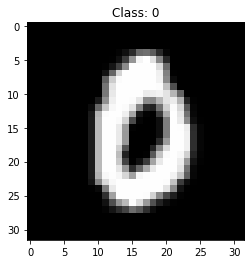

In [21]:
ind = 10 # try 1
plt.figure()
plt.imshow(img[0][ind,0,:,:], cmap='gray')
plt.title("Class: %s" % img[1][ind].item())
plt.show()

In [22]:
def train_and_save_models(epochs = 10, K = 100, modelname = "model-cnn-adv.pt"):
    if os.path.exists(modelname):
        print("File exists")
        return
    # Train with ELBO and Adam (Bayes by Backprop + LRT)
    criterion = common.metrics.ELBO(len(trainset))
    optimizer = Adam(net.parameters(), lr=lr_start)
    lr_sched = lr_scheduler.ReduceLROnPlateau(optimizer, patience=6, verbose=True)
    for epoch in range(epochs):  # loop over the dataset multiple times
        train_loss, train_acc, train_kl = common.train_model(net, optimizer, criterion, train_loader, 
                                                             num_ens=train_ens, beta_type=beta_type, epoch=epoch,
                                                             num_epochs=epochs)
        valid_loss, valid_acc = common.validate_model(net, criterion, valid_loader, num_ens=valid_ens, 
                                                      beta_type=beta_type, epoch=epoch, num_epochs=epochs)
        lr_sched.step(valid_loss)
        print('Epoch:%d, TrainLoss:%.3f, TrainAcc:%.3f, ValLoss:%.3f, ValAcc:%.3f, KL:%.3f' % (
            epoch, train_loss, train_acc, valid_loss, valid_acc, train_kl))
    # Sample k models from the posterior
    nn_dicts = []
    for i in range(K):
        sample_model = LeNet(outputs, inputs, layer_type, activation_type)
        sample_model.sample(net)
        nn_dicts += [sample_model.state_dict()]
    # Save the models
    torch.save(nn_dicts, modelname)
    print("Saved %d models" % K)

In [23]:
train_and_save_models(epochs = 20, K = 1000, modelname = "models/model-cnn-adv-med0.50.pt")

Epoch:0, TrainLoss:675825.725, TrainAcc:0.457, ValLoss:391848.985, ValAcc:0.795, KL:5854286.303
Epoch:1, TrainLoss:299571.643, TrainAcc:0.855, ValLoss:228370.298, ValAcc:0.899, KL:2726808.864
Epoch:2, TrainLoss:182268.922, TrainAcc:0.924, ValLoss:145837.886, ValAcc:0.939, KL:1674113.636
Epoch:3, TrainLoss:121519.875, TrainAcc:0.943, ValLoss:99517.553, ValAcc:0.953, KL:1101698.697
Epoch:4, TrainLoss:85786.966, TrainAcc:0.951, ValLoss:73239.719, ValAcc:0.952, KL:760531.627
Epoch:5, TrainLoss:63224.721, TrainAcc:0.955, ValLoss:54725.575, ValAcc:0.955, KL:543066.877
Epoch:6, TrainLoss:47765.225, TrainAcc:0.958, ValLoss:42697.884, ValAcc:0.958, KL:396992.910
Epoch:7, TrainLoss:37334.873, TrainAcc:0.961, ValLoss:33615.304, ValAcc:0.960, KL:296689.622
Epoch:8, TrainLoss:29801.570, TrainAcc:0.964, ValLoss:27063.225, ValAcc:0.963, KL:225528.364
Epoch:9, TrainLoss:24390.927, TrainAcc:0.965, ValLoss:22116.514, ValAcc:0.967, KL:174635.017
Epoch:10, TrainLoss:20403.011, TrainAcc:0.967, ValLoss:1921

## Adversarial Training (eps= 0.50, champ)

In [24]:
# Train dataset
train_dataset = torchvision.datasets.MNIST('.', train=True, download=True,
                       transform=transform_mnist)

In [25]:
transform_back = transforms.Compose([transforms.Resize((28,28))])

In [26]:
dirs    = [d for d in os.listdir("mnist_adv_CNN_0.50/") if d.startswith("train_images_champ")]
dir_ord = sorted([int(re.findall("[0-9]+",d)[0]) for d in dirs])
dirs    = sorted(dirs, key=lambda x: dir_ord.index(int(re.findall("[0-9]+",x)[0])))

In [27]:
images  = []
targets = []
for d in dirs:
    with open("mnist_adv_CNN_0.50/" + d, 'rb') as handle:
        temp = pickle.load(handle)
        images.append(temp["images"])
        targets.append(temp["labels"])
        
images  = torch.vstack(images)
images  = transform_back(images)
images  = images[:,0,:,:]

targets = torch.hstack(targets)

In [28]:
train_dataset.data    = torch.vstack([train_dataset.data, images])
train_dataset.targets = torch.hstack([train_dataset.targets, targets])

train, val = random_split(train_dataset,[50000+images.shape[0],10000], generator=torch.Generator().manual_seed(156))

# Train data loader
train_loader = torch.utils.data.DataLoader(train, batch_size=128, shuffle=True)
valid_loader = torch.utils.data.DataLoader(val  , batch_size=128, shuffle=True)

In [29]:
img = next(iter(train_loader))

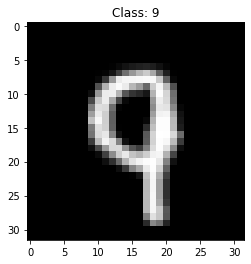

In [191]:
ind = 10 # try 1
plt.figure()
plt.imshow(img[0][ind,0,:,:], cmap='gray')
plt.title("Class: %s" % img[1][ind].item())
plt.show()

In [30]:
def train_and_save_models(epochs = 10, K = 100, modelname = "model-cnn-adv.pt"):
    if os.path.exists(modelname):
        print("File exists")
        return
    # Train with ELBO and Adam (Bayes by Backprop + LRT)
    criterion = common.metrics.ELBO(len(trainset))
    optimizer = Adam(net.parameters(), lr=lr_start)
    lr_sched = lr_scheduler.ReduceLROnPlateau(optimizer, patience=6, verbose=True)
    for epoch in range(epochs):  # loop over the dataset multiple times
        train_loss, train_acc, train_kl = common.train_model(net, optimizer, criterion, train_loader, 
                                                             num_ens=train_ens, beta_type=beta_type, epoch=epoch,
                                                             num_epochs=epochs)
        valid_loss, valid_acc = common.validate_model(net, criterion, valid_loader, num_ens=valid_ens, 
                                                      beta_type=beta_type, epoch=epoch, num_epochs=epochs)
        lr_sched.step(valid_loss)
        print('Epoch:%d, TrainLoss:%.3f, TrainAcc:%.3f, ValLoss:%.3f, ValAcc:%.3f, KL:%.3f' % (
            epoch, train_loss, train_acc, valid_loss, valid_acc, train_kl))
    # Sample k models from the posterior
    nn_dicts = []
    for i in range(K):
        sample_model = LeNet(outputs, inputs, layer_type, activation_type)
        sample_model.sample(net)
        nn_dicts += [sample_model.state_dict()]
    # Save the models
    torch.save(nn_dicts, modelname)
    print("Saved %d models" % K)

In [31]:
train_and_save_models(epochs = 20, K = 1000, modelname = "models/model-cnn-adv-champ0.50.pt")

Epoch:0, TrainLoss:11447.010, TrainAcc:0.964, ValLoss:12110.118, ValAcc:0.960, KL:41448.903
Epoch:1, TrainLoss:10468.662, TrainAcc:0.968, ValLoss:11019.912, ValAcc:0.966, KL:41057.046
Epoch:2, TrainLoss:10102.776, TrainAcc:0.970, ValLoss:11801.397, ValAcc:0.965, KL:40567.095
Epoch:3, TrainLoss:9841.269, TrainAcc:0.971, ValLoss:11380.596, ValAcc:0.966, KL:39981.229
Epoch:4, TrainLoss:9370.015, TrainAcc:0.973, ValLoss:10870.233, ValAcc:0.968, KL:39506.889
Epoch:5, TrainLoss:9230.336, TrainAcc:0.973, ValLoss:11161.190, ValAcc:0.965, KL:39060.530
Epoch:6, TrainLoss:9182.682, TrainAcc:0.974, ValLoss:10442.827, ValAcc:0.971, KL:38616.062
Epoch:7, TrainLoss:8928.359, TrainAcc:0.975, ValLoss:10332.060, ValAcc:0.971, KL:38268.065
Epoch:8, TrainLoss:8604.883, TrainAcc:0.976, ValLoss:10822.201, ValAcc:0.966, KL:37845.888
Epoch:9, TrainLoss:8527.583, TrainAcc:0.976, ValLoss:10335.241, ValAcc:0.970, KL:37333.202
Epoch:10, TrainLoss:8416.549, TrainAcc:0.977, ValLoss:10067.828, ValAcc:0.973, KL:37064

## Adversarial Training (eps= 0.50, mean)

In [32]:
# Train dataset
train_dataset = torchvision.datasets.MNIST('.', train=True, download=True,
                       transform=transform_mnist)

In [33]:
transform_back = transforms.Compose([transforms.Resize((28,28))])

In [34]:
dirs    = [d for d in os.listdir("mnist_adv_CNN_0.50/") if d.startswith("train_images_mean")]
dir_ord = sorted([int(re.findall("[0-9]+",d)[0]) for d in dirs])
dirs    = sorted(dirs, key=lambda x: dir_ord.index(int(re.findall("[0-9]+",x)[0])))

In [35]:
images  = []
targets = []
for d in dirs:
    with open("mnist_adv_CNN_0.50/" + d, 'rb') as handle:
        temp = pickle.load(handle)
        images.append(temp["images"])
        targets.append(temp["labels"])
        
images  = torch.vstack(images)
images  = transform_back(images)
images  = images[:,0,:,:]

targets = torch.hstack(targets)

In [36]:
train_dataset.data    = torch.vstack([train_dataset.data, images])
train_dataset.targets = torch.hstack([train_dataset.targets, targets])

train, val = random_split(train_dataset,[50000+images.shape[0],10000], generator=torch.Generator().manual_seed(156))

# Train data loader
train_loader = torch.utils.data.DataLoader(train, batch_size=128, shuffle=True)
valid_loader = torch.utils.data.DataLoader(val  , batch_size=128, shuffle=True)

In [37]:
img = next(iter(train_loader))

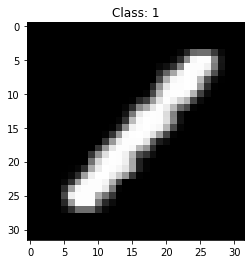

In [38]:
ind = 10 # try 1
plt.figure()
plt.imshow(img[0][ind,0,:,:], cmap='gray')
plt.title("Class: %s" % img[1][ind].item())
plt.show()

In [39]:
def train_and_save_models(epochs = 10, K = 100, modelname = "model-cnn-adv.pt"):
    if os.path.exists(modelname):
        print("File exists")
        return
    # Train with ELBO and Adam (Bayes by Backprop + LRT)
    criterion = common.metrics.ELBO(len(trainset))
    optimizer = Adam(net.parameters(), lr=lr_start)
    lr_sched = lr_scheduler.ReduceLROnPlateau(optimizer, patience=6, verbose=True)
    for epoch in range(epochs):  # loop over the dataset multiple times
        train_loss, train_acc, train_kl = common.train_model(net, optimizer, criterion, train_loader, 
                                                             num_ens=train_ens, beta_type=beta_type, epoch=epoch,
                                                             num_epochs=epochs)
        valid_loss, valid_acc = common.validate_model(net, criterion, valid_loader, num_ens=valid_ens, 
                                                      beta_type=beta_type, epoch=epoch, num_epochs=epochs)
        lr_sched.step(valid_loss)
        print('Epoch:%d, TrainLoss:%.3f, TrainAcc:%.3f, ValLoss:%.3f, ValAcc:%.3f, KL:%.3f' % (
            epoch, train_loss, train_acc, valid_loss, valid_acc, train_kl))
    # Sample k models from the posterior
    nn_dicts = []
    for i in range(K):
        sample_model = LeNet(outputs, inputs, layer_type, activation_type)
        sample_model.sample(net)
        nn_dicts += [sample_model.state_dict()]
    # Save the models
    torch.save(nn_dicts, modelname)
    print("Saved %d models" % K)

In [40]:
train_and_save_models(epochs = 20, K = 1000, modelname = "models/model-cnn-adv-mean0.50.pt")

Epoch:0, TrainLoss:7816.244, TrainAcc:0.978, ValLoss:8978.572, ValAcc:0.975, KL:34282.621
Epoch:1, TrainLoss:7175.247, TrainAcc:0.981, ValLoss:8651.983, ValAcc:0.975, KL:34162.568
Epoch:2, TrainLoss:6896.807, TrainAcc:0.982, ValLoss:8236.008, ValAcc:0.978, KL:33810.304
Epoch:3, TrainLoss:6808.142, TrainAcc:0.982, ValLoss:8411.853, ValAcc:0.977, KL:33527.100
Epoch:4, TrainLoss:6552.725, TrainAcc:0.984, ValLoss:8473.825, ValAcc:0.977, KL:33169.438
Epoch:5, TrainLoss:6624.577, TrainAcc:0.983, ValLoss:8340.197, ValAcc:0.977, KL:32946.340
Epoch:6, TrainLoss:6496.584, TrainAcc:0.984, ValLoss:8526.166, ValAcc:0.978, KL:32697.437
Epoch:7, TrainLoss:6362.987, TrainAcc:0.984, ValLoss:8186.024, ValAcc:0.979, KL:32575.957
Epoch:8, TrainLoss:6394.714, TrainAcc:0.984, ValLoss:7991.355, ValAcc:0.979, KL:32498.601
Epoch:9, TrainLoss:6245.356, TrainAcc:0.985, ValLoss:7960.434, ValAcc:0.978, KL:32414.938
Epoch:10, TrainLoss:6341.532, TrainAcc:0.984, ValLoss:7843.233, ValAcc:0.979, KL:32178.055
Epoch:11,

## Code Testing

In [105]:
import torch, torchvision
import numpy as np
import matplotlib.pyplot as plt
import pyro
import tqdm
import os
import common
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
from torch.optim import Adam, lr_scheduler

import re, pickle
from torch.utils.data import DataLoader, random_split

common.set_seed(1)

# Settings
HOME_DIR = "/home/fcbeylun/adv-bnn/"
HOME_DIR = "./"
EPS  = 0.05
COMB = "champ"

# for GPU
# CUDA settings
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Configuration parameters
layer_type = 'lrt'  # 'bbb' or 'lrt'
activation_type = 'softplus'  # 'softplus' or 'relu'
priors={
    'prior_mu': 0,
    'prior_sigma': 0.1,
    'posterior_mu_initial': (0, 0.1),  # (mean, std) normal_
    'posterior_rho_initial': (-5, 0.1),  # (mean, std) normal_
}
lr_start = 0.001
num_workers = 1
valid_size = 0.2
batch_size = 256
train_ens = 1
valid_ens = 1
beta_type = 0.1

net_type = 'lenet'   # (lenet/alexnet)
dataset  = 'mnist'    # (mnist/cifar10/cifar100)


if dataset == 'mnist':
    transform = transforms.Compose([
                transforms.Resize((32, 32)),
                transforms.ToTensor(),
    ])
    inputs = 1
    outputs = 10
    trainset = torchvision.datasets.MNIST(root=HOME_DIR, train=True, download=True, transform=transform)
elif dataset == 'cifar10':
    transform = transforms.Compose([
                transforms.ToTensor(),
    ])
    inputs = 3
    outputs = 10
    trainset = torchvision.datasets.CIFAR10(root=HOME_DIR, train=True, download=True, transform=transform)
elif dataset == 'cifar100':
    transform = transforms.Compose([
            transforms.Resize((32, 32)),
            transforms.ToTensor(),
    ])
    inputs = 3
    outputs = 100
    trainset = torchvision.datasets.CIFAR100(root=HOME_DIR, train=True, download=True, transform=transform)
else:
    raise RuntimeException("Unsupported dataset")


if net_type == 'lenet':
    net_class = common.non_bayesian_models.LeNet
    bbb_model = common.bayesian_models.BBBLeNet
elif net_type == 'alexnet':
    net_class = common.non_bayesian_models.AlexNet
    bbb_model = common.bayesian_models.BBBAlexNet
else:
    raise RuntimeException("Unsupported network type")


net = bbb_model(outputs, inputs, priors, layer_type, activation_type).to(device)


def train_and_save_models(epochs = 10, K = 100, modelname = "model-cnn.pt", force_train=False):
    if os.path.exists(modelname) and not force_train:
        print("File exists")
        return
    # Train with ELBO and Adam (Bayes by Backprop + LRT)
    criterion = common.metrics.ELBO(len(trainset)).to(device)
    optimizer = Adam(net.parameters(), lr=lr_start)
    lr_sched = lr_scheduler.ReduceLROnPlateau(optimizer, patience=6, verbose=True)
    for epoch in range(epochs):  # loop over the dataset multiple times
        train_loss, train_acc, train_kl = common.train_model(net, optimizer, criterion, train_loader,
                                                             num_ens=train_ens, beta_type=beta_type, epoch=epoch,
                                                             num_epochs=epochs)
        valid_loss, valid_acc = common.validate_model(net, criterion, valid_loader, num_ens=valid_ens,
                                                      beta_type=beta_type, epoch=epoch, num_epochs=epochs)
        lr_sched.step(valid_loss)
        print('Epoch:%d, TrainLoss:%.3f, TrainAcc:%.3f, ValLoss:%.3f, ValAcc:%.3f, KL:%.3f' % (
            epoch, train_loss, train_acc, valid_loss, valid_acc, train_kl))
    # Sample k models from the posterior
    nn_dicts = []
    for i in range(K):
        sample_model = net_class(outputs, inputs, layer_type, activation_type).to(device)
        sample_model.sample(net)
        nn_dicts += [sample_model.state_dict()]
    # Save the models
    torch.save(nn_dicts, modelname)
    print("Saved %d models" % K)

# Train dataset
train_dataset = trainset

dirs    = [d for d in os.listdir(HOME_DIR + "mnist_adv_CNN_itcm_%s/" % EPS) if d.startswith("train_images_%s" % COMB)]
dir_ord = sorted([int(re.findall("[0-9]+",d)[0]) for d in dirs])
dirs    = sorted(dirs, key=lambda x: dir_ord.index(int(re.findall("[0-9]+",x)[0])))

transform_back = transforms.Compose([transforms.Resize((28,28))])


images  = []
targets = []
for d in dirs:
    with open(HOME_DIR + "mnist_adv_CNN_itcm_%s/" % EPS + d, 'rb') as handle:
        temp = pickle.load(handle)
        images.append(temp["images"])
        targets.append(temp["labels"])

images  = torch.vstack(images)
images  = transform_back(images)
print(images.shape)
targets = torch.hstack(targets)

torch.Size([4, 28, 28])


In [92]:
train_dataset.data.shape

torch.Size([60000, 28, 28])

In [93]:
train_dataset.data    = torch.vstack([train_dataset.data, images])

In [103]:
targets = torch.tensor(sum([t.detach().tolist() for t in targets],[]))

In [106]:
train_dataset.targets = torch.hstack([train_dataset.targets, targets])